<a href="https://colab.research.google.com/github/tankyven/Data-Science/blob/master/BC3409_PA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Code from Local Computer

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


# Pre-processing

In [0]:
# Import files
df_crude = pd.read_csv('Crude Oil Price from 1986.csv')
df_dow = pd.read_csv('DJI 1985 to 2019 for Practical Assessment 1.csv')
df_oil_future = pd.read_csv('Brent_Crude_Futures.csv')
df_CN_gdp = pd.read_csv('China_Q_GDP.csv')
df_CN_pct = pd.read_csv('China_gdp_pct_chg.csv')
df_useu = pd.read_csv('US_EU_Forex.csv')
df_US_gdp = pd.read_csv('US_real_gdp.csv')
df_libor = pd.read_csv('historical-libor-rates-chart.csv')

In [0]:
# Cleaning crude oil dataframe
df_crude.head()

,DATE,DCOILWTICO
0,2/1/1986,25.56
1,3/1/1986,26
2,6/1/1986,26.53
3,7/1/1986,25.85
4,8/1/1986,25.87


In [0]:
df_dow.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29/1/1985,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,30/1/1985,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,31/1/1985,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1/2/1985,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,4/2/1985,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [0]:
df_oil_future.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2019-04-12,NaN,NaN,NaN,64.26,0.40,NaN,NaN,641.0,NaN,NaN,NaN
1,2019-04-11,NaN,NaN,NaN,63.86,-0.27,NaN,NaN,641.0,NaN,NaN,NaN
2,2019-04-10,NaN,NaN,NaN,64.13,0.63,NaN,NaN,641.0,NaN,NaN,NaN
3,2019-04-09,NaN,NaN,NaN,63.50,0.00,NaN,NaN,641.0,NaN,NaN,NaN
4,2019-04-08,NaN,NaN,NaN,63.50,0.15,NaN,NaN,641.0,NaN,NaN,NaN


In [0]:
df_CN_gdp.head()

,DATE,CHNGDPNQDSMEI,Month,Year
0,1992-01-01,5.262800e+11,1,1992
1,1992-04-01,6.484300e+11,4,1992
2,1992-07-01,7.192600e+11,7,1992
3,1992-10-01,8.254800e+11,10,1992
4,1993-01-01,6.834600e+11,1,1993


In [0]:
df_CN_pct.head()

,DATE,CHNGDPRAPSMEI
0,1971-01-01,7.075491
1,1972-01-01,3.826356
2,1973-01-01,7.772820
3,1974-01-01,2.335923
4,1975-01-01,8.704194


In [0]:
df_useu.head()

,DATE,DEXUSEU
0,1999-01-04,1.1812
1,1999-01-05,1.1760
2,1999-01-06,1.1636
3,1999-01-07,1.1672
4,1999-01-08,1.1554


In [0]:
df_US_gdp.head()

,DATE,GDPC1,Month,Year
0,1947-01-01,2033.061,1,1947
1,1947-04-01,2027.639,4,1947
2,1947-07-01,2023.452,7,1947
3,1947-10-01,2055.103,10,1947
4,1948-01-01,2086.017,1,1948


In [0]:
df_libor.head()

,date,value,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1/1/86,8.25,8.25,8.25,8.50
1,1/2/86,7.94,7.88,7.88,7.94
2,1/3/86,7.50,7.44,7.44,7.44
3,1/4/86,6.94,6.88,6.88,6.94
4,1/5/86,7.13,7.13,7.19,7.38


In [0]:
# Remove unnecessary columns
df_dow = df_dow.drop(labels=['Open','High','Low','Close','Volume'], axis=1)
df_oil_future = df_oil_future.drop(labels=['Open', 'High', 'Low', 'Change', 'Wave', 'Volume',
                           'Prev. Day Open Interest', 'EFP Volume', 'EFS Volume', 'Block Volume'], axis=1)

df_libor = df_libor.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [0]:
# Correct datetime format
df_crude['DATE'] = pd.to_datetime(df_crude['DATE'], format='%d/%m/%Y')
df_dow['Date'] = pd.to_datetime(df_dow['Date'], format='%d/%m/%Y')
df_oil_future['Date'] = pd.to_datetime(df_oil_future['Date'], format='%Y-%m-%d')
df_CN_gdp['DATE'] = pd.to_datetime(df_CN_gdp['DATE'],format='%Y-%m-%d')
df_CN_pct['DATE'] = pd.to_datetime(df_CN_pct['DATE'],format='%Y-%m-%d')
df_useu['DATE'] = pd.to_datetime(df_useu['DATE'],format='%Y-%m-%d')
df_US_gdp['DATE'] = pd.to_datetime(df_US_gdp['DATE'],format='%Y-%m-%d')
df_libor['date'] = pd.to_datetime(df_libor['date'], format='%d/%m/%y')

In [0]:
# Extract month & year column
df_crude['Month'] = df_crude['DATE'].dt.month
df_dow['Month'] = df_dow['Date'].dt.month
df_oil_future['Month'] = df_oil_future['Date'].dt.month
df_CN_gdp['Month'] = df_CN_gdp['DATE'].dt.month
df_CN_pct['Month'] = df_CN_pct['DATE'].dt.month
df_useu['Month'] = df_useu['DATE'].dt.month
df_US_gdp['Month'] = df_US_gdp['DATE'].dt.month
df_libor['Month'] = df_libor['date'].dt.month

df_crude['Year'] = df_crude['DATE'].dt.year
df_dow['Year'] = df_dow['Date'].dt.year
df_oil_future['Year'] = df_oil_future['Date'].dt.year
df_CN_gdp['Year'] = df_CN_gdp['DATE'].dt.year
df_CN_pct['Year'] = df_CN_pct['DATE'].dt.year
df_useu['Year'] = df_useu['DATE'].dt.year
df_US_gdp['Year'] = df_US_gdp['DATE'].dt.year
df_libor['Year'] = df_libor['date'].dt.year

In [0]:
# Merge data together
master_df = pd.merge(df_crude, df_dow, left_on='DATE', right_on='Date', how='inner')
master_df = master_df.drop(labels=['Month_x','Year_x','Date'], axis=1)
master_df = pd.merge(master_df, df_oil_future, left_on='DATE', right_on='Date', how='inner')
master_df = master_df.drop(labels=['Month_y','Year_y','Date'], axis=1)
master_df = pd.merge(master_df, df_useu, on='DATE', how='inner')
master_df = master_df.drop(labels=['Month_x','Year_x'], axis=1)
master_df = pd.merge(master_df, df_libor,  how='inner', left_on=['Month_y','Year_y'], right_on = ['Month','Year'])
master_df = master_df.drop(labels=['Month_y','Year_y','date'], axis=1)
master_df = pd.merge(master_df, df_CN_pct, on='Year', how='inner')
master_df = master_df.drop(labels=['Month_x','DATE_y'], axis=1)

# Merge GDP columns
CNUS_gdp_df = pd.merge(df_CN_gdp, df_US_gdp, on='DATE', how='inner')
CNUS_gdp_df = CNUS_gdp_df.drop(labels=['Month_x','Year_x'], axis=1)

master_df = pd.merge(master_df, CNUS_gdp_df, left_on=['Month_y','Year'], right_on=['Month_y','Year_y'], how='left')
master_df = master_df.drop(labels=['DATE','Year'], axis=1)


In [0]:
# Rename columns
master_df.columns = ['Date','crude_price','dow_close_price','crude_futures','us/eu','%libor','cn_gdp_chg','Month','cn_gdp','us_gdp','Year']
master_df = master_df.drop(labels=['Month','Year'],axis=1)
master_df.head()


,Date,crude_price,dow_close_price,crude_futures,us/eu,%libor,cn_gdp_chg,cn_gdp,us_gdp
0,1999-01-04,12.42,9184.269531,11.34,1.1812,4.94,7.66153,1.936190e+12,12403.293
1,1999-01-05,12.04,9311.190430,10.91,1.1760,4.94,7.66153,1.936190e+12,12403.293
2,1999-01-06,12.84,9544.969727,11.60,1.1636,4.94,7.66153,1.936190e+12,12403.293
3,1999-01-07,12.99,9537.759766,11.54,1.1672,4.94,7.66153,1.936190e+12,12403.293
4,1999-01-08,13.06,9643.320313,11.75,1.1554,4.94,7.66153,1.936190e+12,12403.293


In [0]:
# Drop outliers from dow price
master_df = master_df.drop([454,1394,2264,3320,4241],axis=0)

In [0]:
# Remove mistakes
crude_drop = master_df[master_df['crude_price'] == '.']['crude_price'].index
master_df = master_df.drop(labels=crude_drop,axis=0)
us_eu_drop = master_df[master_df['us/eu'] == '.']['us/eu'].index
master_df = master_df.drop(labels=us_eu_drop,axis=0)

In [0]:
# Convert columns to float
master_df['crude_price'] = pd.to_numeric(master_df['crude_price'])
master_df['us/eu'] = pd.to_numeric(master_df['us/eu'])

In [0]:
# Output master csv
master_df.to_csv('master_df.csv', index=False)

# Exploratory Data Analysis

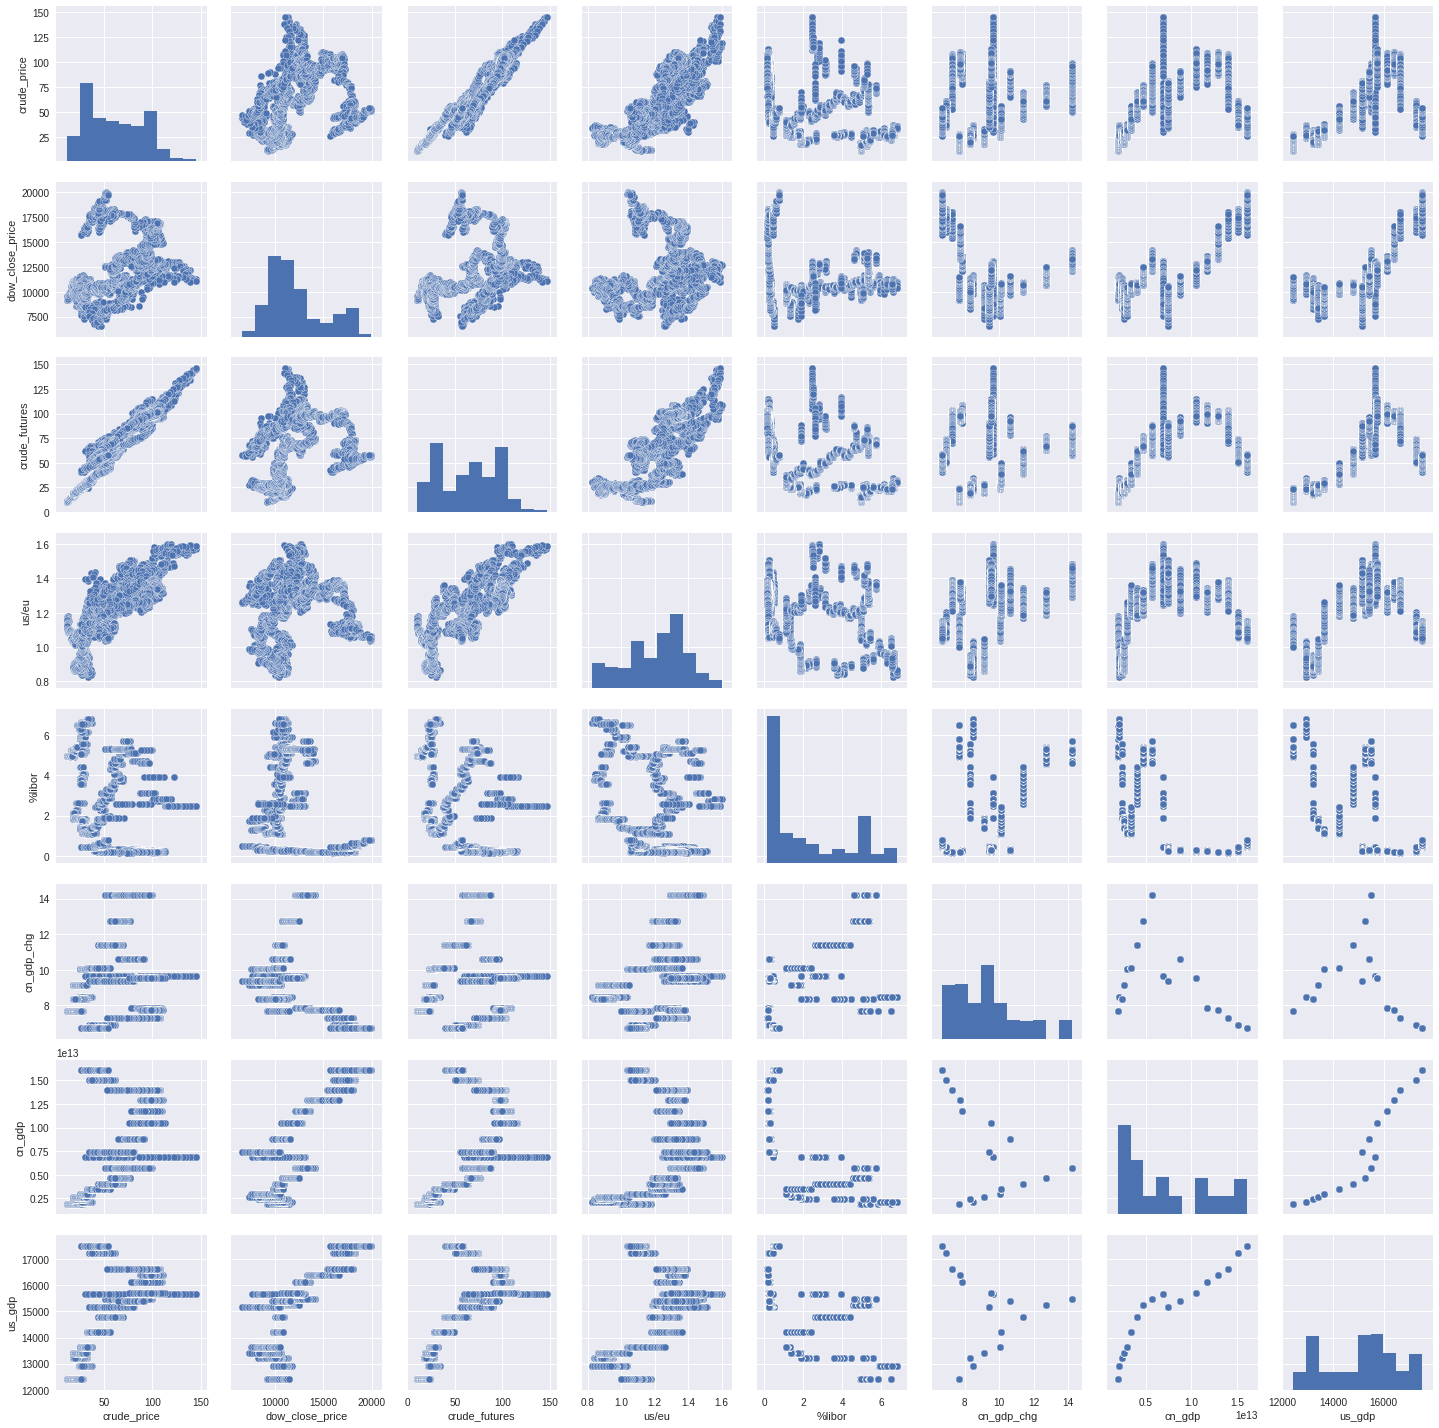

In [0]:
sns.pairplot(data=master_df)

In [0]:
# import master_csv
cleaned_master_df = pd.read_csv('master_df.csv')
cleaned_master_df.head()

,Date,crude_price,dow_close_price,crude_futures,us/eu,%libor,cn_gdp_chg,cn_gdp,us_gdp,high_low
0,4/1/99,12.42,9184.269531,11.34,1.1812,4.94,7.66153,1.940000e+12,12403.293,0
1,5/1/99,12.04,9311.190430,10.91,1.1760,4.94,7.66153,1.940000e+12,12403.293,0
2,6/1/99,12.84,9544.969727,11.60,1.1636,4.94,7.66153,1.940000e+12,12403.293,0
3,7/1/99,12.99,9537.759766,11.54,1.1672,4.94,7.66153,1.940000e+12,12403.293,0
4,8/1/99,13.06,9643.320313,11.75,1.1554,4.94,7.66153,1.940000e+12,12403.293,0


**high_low represents whether there is a buying opportunity based on current day crude oil prices.**

*   0: Current crude_price >= crude_price 30 trading days from now
*   1: Current crude price < crude_price 30 trading days from now



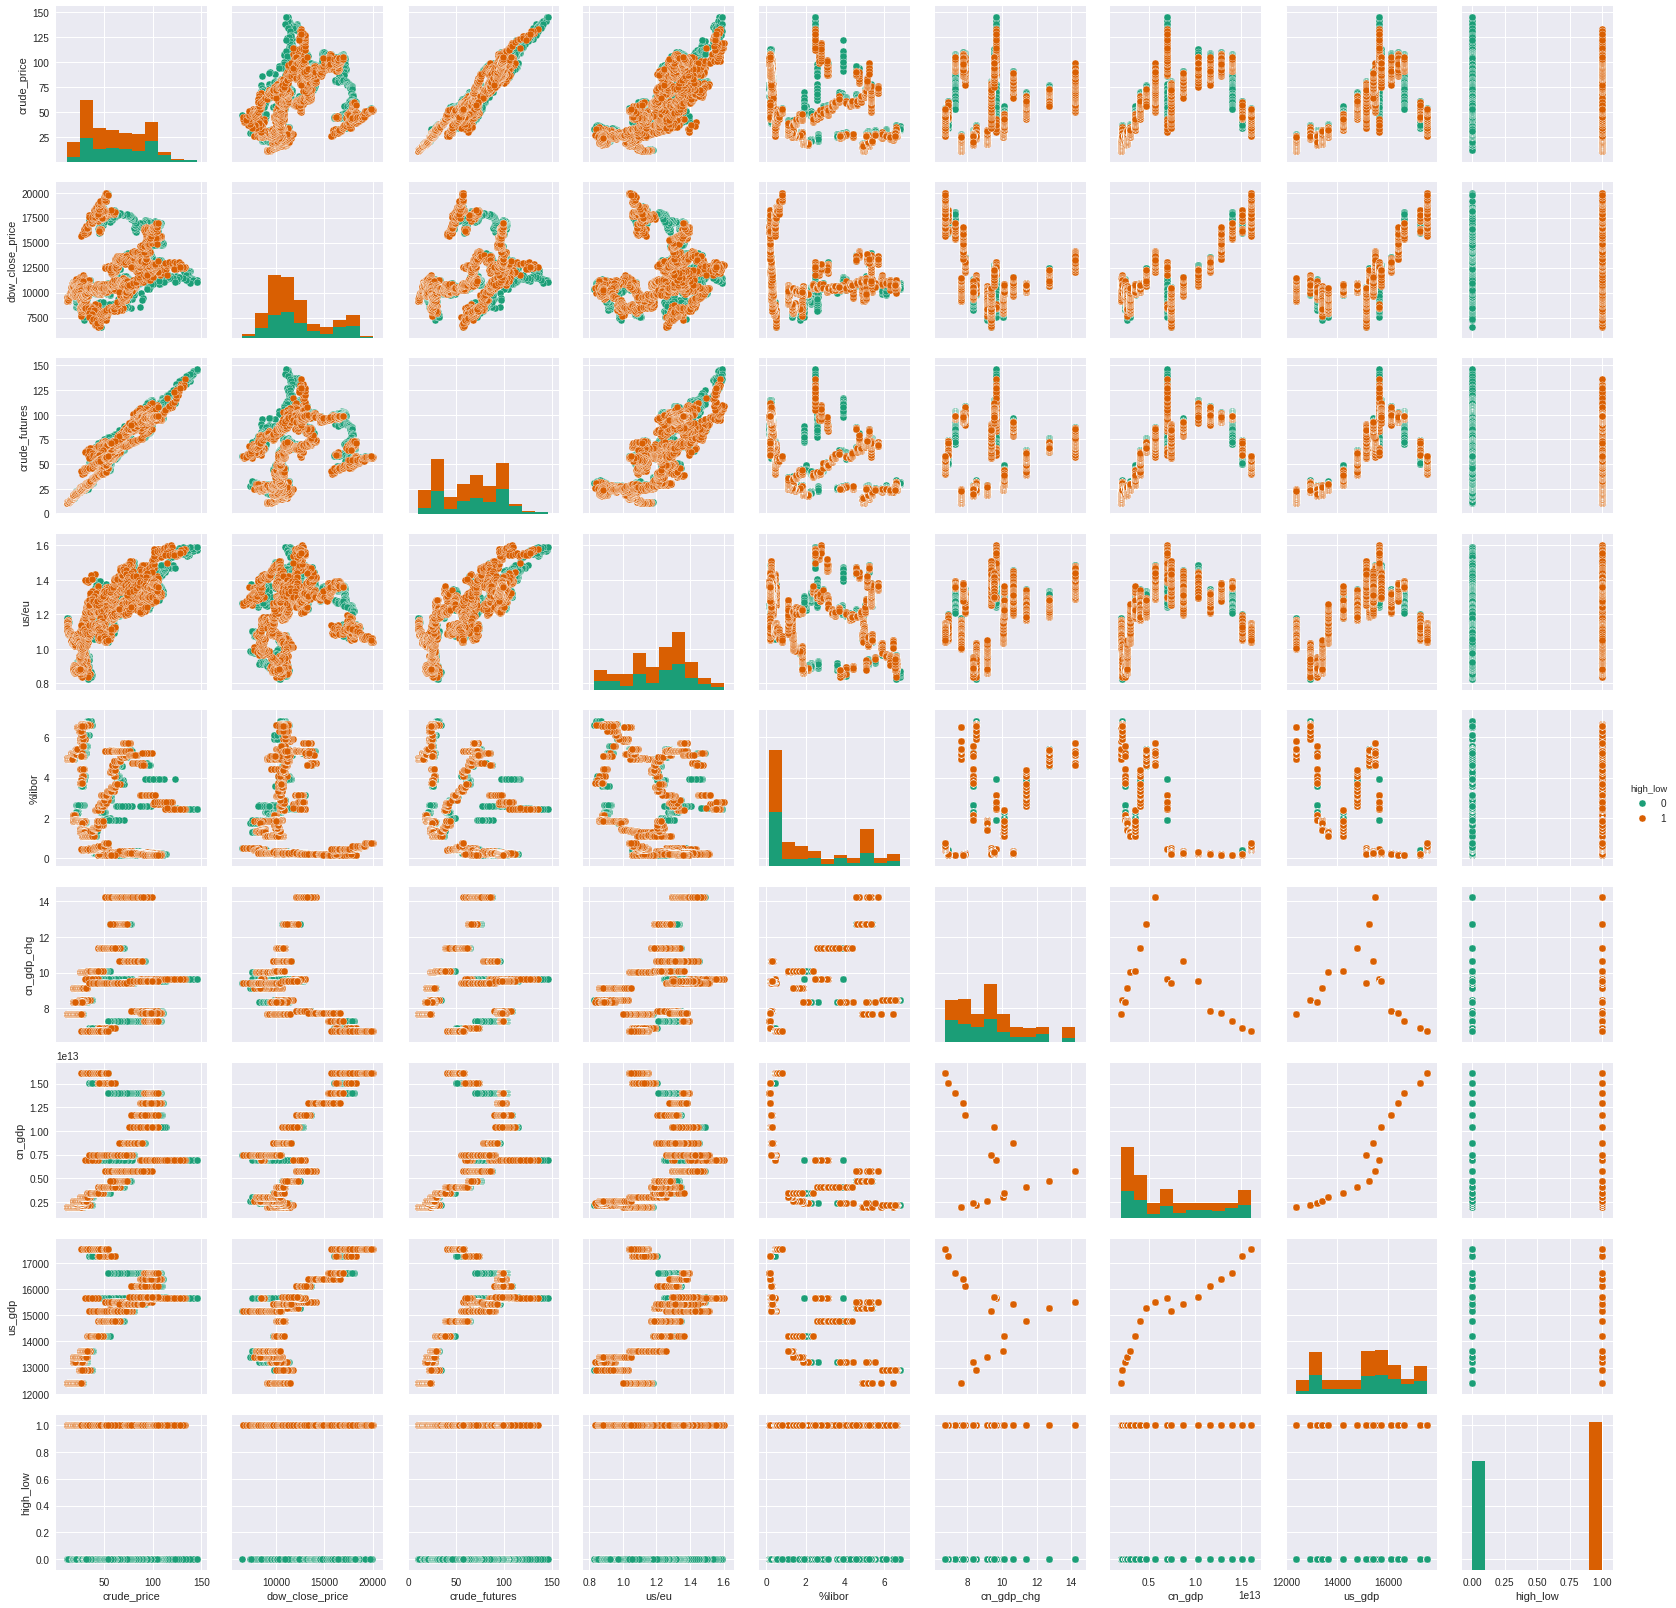

In [0]:
sns.pairplot(cleaned_master_df,hue='high_low',palette='Dark2')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Distribution of Target Class')

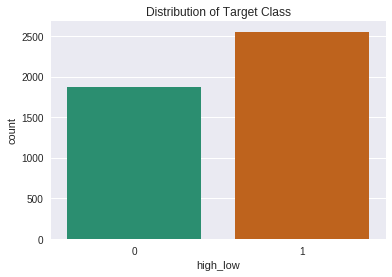

In [0]:
sns.countplot('high_low', data=cleaned_master_df, palette='Dark2')
plt.title('Distribution of Target Class')

In [0]:
print('Percentage of 1s: {}%'.format(round(cleaned_master_df['high_low'].value_counts()[1]/len(cleaned_master_df),2)))
print('Percentage of 0s: {}%'.format(round(cleaned_master_df['high_low'].value_counts()[0]/len(cleaned_master_df),2)))

Percentage of 1s: 0.58%
Percentage of 0s: 0.42%


# Modelling

## Train test split

In [0]:
# Test set comprises of data from 3/8/11 - 30/12/16
X = cleaned_master_df.drop(labels=['high_low','Date'], axis=1)
y = cleaned_master_df['high_low']

train_len = int(len(cleaned_master_df)*0.7)

train_X = X[0:train_len]
train_y = y[0:train_len]
test_X = X[train_len:]
test_y = y[train_len:]

## SVM

### Train Model

Using grid search, find the most optimal parameters for the model with the highest accuracy in predicting the high_low class.

In [0]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [0]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.2s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total=   0.2s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.2s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.2s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.2s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   12.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

### Evaluate SVM model

In [0]:
round(accuracy_score(y_test,grid_predictions),3)

0.698

In [0]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('Accuracy: {}'.format(round(accuracy_score(y_test,grid_predictions),3)))

[[363 161]
 [240 563]]
Accuracy: 0.698


In [0]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       524
           1       0.78      0.70      0.74       803

   micro avg       0.70      0.70      0.70      1327
   macro avg       0.69      0.70      0.69      1327
weighted avg       0.71      0.70      0.70      1327



## LSTM

### Train Model

In [0]:
# Test set comprises of data from 3/8/11 - 30/12/16
X = cleaned_master_df.drop(labels=['high_low','Date'], axis=1)
y = cleaned_master_df['high_low']

# Scaling features in X & y
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_X = scaler.fit_transform(X)

train_len = int(len(cleaned_master_df)*0.7)

X_train = scaled_data_X[0:train_len]
y_train = y[0:train_len]
X_test = scaled_data_X[train_len:]
y_test = y[train_len:]

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 12s - loss: 0.7918 - acc: 0.5279
Epoch 2/10
 - 10s - loss: 0.6841 - acc: 0.5884
Epoch 3/10
 - 11s - loss: 0.6691 - acc: 0.6078
Epoch 4/10
 - 10s - loss: 0.6647 - acc: 0.6142
Epoch 5/10
 - 10s - loss: 0.6643 - acc: 0.6129
Epoch 6/10
 - 10s - loss: 0.6665 - acc: 0.6048
Epoch 7/10
 - 10s - loss: 0.6581 - acc: 0.6145
Epoch 8/10
 - 10s - loss: 0.6596 - acc: 0.6107
Epoch 9/10
 - 10s - loss: 0.6552 - acc: 0.6191
Epoch 10/10
 - 10s - loss: 0.6552 - acc: 0.6132


### Evaluate LSTM Model

In [0]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 49.43%
